# CoMPARA Predictions and Unrestricted Dataset Cross-Validation

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

import ml
import utils
import analysis 

c:\Users\GNZFG\AppData\Local\miniforge-pypy3\envs\AndroR\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
andror_df_all = pd.read_csv("../andror_df_all_clusters.csv", index_col=0)

In [3]:
andror_df_pub = pd.read_csv("../AndroR_4_final_dataset_training_PUB_STD_rdkit.csv", index_col=0)

In [4]:
andror_df_all["unrestricted"] = andror_df_all["Compound No"].isin(andror_df_pub["Compound No"])

In [5]:
rdkit_descriptors = pd.read_csv("rdkit_descriptors.csv", index_col=0)

In [6]:
andror_df_pub = andror_df_all[andror_df_all["unrestricted"]]
rdkit_descriptors_pub = rdkit_descriptors.loc[andror_df_all[andror_df_all["unrestricted"]].index]

In [7]:
fps = utils.get_fingerprints(andror_df_pub)

In [8]:
groups = utils.get_cluster_assignments_from_fps(fps, 0.65, chunk_size=5000)

# Cross-validation on unrestricted Dataset

In [9]:
splits_rdkit_descriptors_unrestricted, pipelines_rdkit_descriptors_unrestricted = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors_pub, 
    y=andror_df_pub["final class"], 
    groups=groups, 
    training_name="RDKit_descriptors_unrestricted",
)

Repetitions: 100%|██████████| 5/5 [1:52:22<00:00, 1348.44s/it]


In [10]:
CV_unrestricted = analysis.CV(splits_rdkit_descriptors_unrestricted)

In [11]:
splits_rdkit_descriptors, pipelines_rdkit_descriptors = ml.run_or_retrieve_from_disc(
    X=rdkit_descriptors, 
    y=andror_df_all["final class"], 
    groups=andror_df_all["cluster_065"], 
    training_name="RDKit_descriptors",
)

In [12]:
CV_full = analysis.CV(splits_rdkit_descriptors)

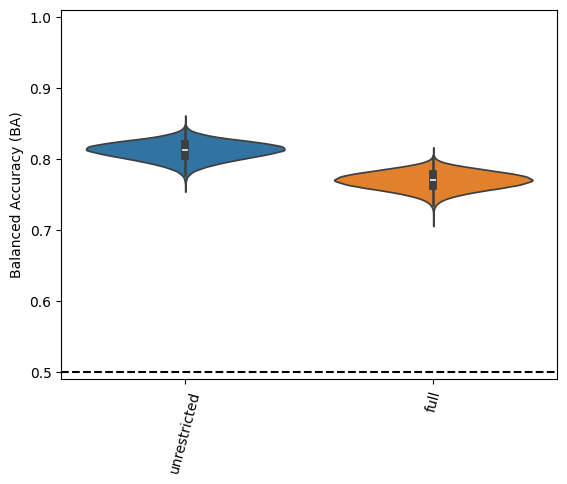

In [13]:
comparison_df_CV = analysis.violinplot_bayesian_estimate_of_performance_metrics({
    "unrestricted": CV_unrestricted,
    "full": CV_full,
}, sel_metric="balanced accuracy")

In [14]:
comparison_df_CV.describe().loc[["mean", "std"]]

,unrestricted,full
mean,0.811817,0.769582
std,0.012600,0.012356


Calculate all metrics of interest so we can compare them to the full HTS data model.

In [17]:
plt.ioff()


for curr_ds, curr_CV in {"unrestricted": CV_unrestricted, "full": CV_full}.items():
    performance_metric = {}
    for sel_metric in ["MCC", "balanced accuracy", "NPV", "TNR", "PPV", "TPR"]:
        curr_comparison_df_CV = analysis.violinplot_bayesian_estimate_of_performance_metrics({
            curr_ds: curr_CV,
        }, sel_metric=sel_metric)

        performance_metric[sel_metric] = curr_comparison_df_CV.describe().loc[["mean", "std"]].T.iloc[0]
    
    print(curr_ds)
    print(pd.DataFrame(performance_metric))

plt.ion()

unrestricted
           MCC  balanced accuracy       NPV       TNR       PPV       TPR
mean  0.500666           0.811825  0.959166  0.817934  0.442957  0.805720
std   0.021670           0.012567  0.004829  0.010103  0.022484  0.025449
full
           MCC  balanced accuracy       NPV       TNR       PPV       TPR
mean  0.286319           0.769592  0.982000  0.771904  0.170204  0.767173
std   0.016488           0.012317  0.002008  0.009800  0.013133  0.025837
